## Imports

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

import milton_maps as mm

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_context("notebook")

## Load cleaned and processed input files

This notebook works from cleaned and transformed data.  The transformation pipeline is defined in `dvc.yaml`.  To simply work with the latest version, pull the appropriate versions from dvc using `dvc pull`.  To regenerate the files, perhaps with local code changes, run `dvc repro`.

In [2]:
town_boundaries = gpd.read_file("../data/processed/town_boundaries.shp.zip").set_index("TOWN_ID")
milton_quincy_boundaries = town_boundaries[town_boundaries.TOWN.isin(["MILTON", "QUINCY"])]

In [3]:
milton_quincy_boundaries

,TOWN,POP1980,POP1990,POP2000,POPCH90_00,TYPE,FOURCOLOR,FIPS_STCO,CCD_MCD,FIPS_PLACE,FIPS_MCD,FIPS_COUNT,POP2010,POPCH00_10,POPCH80_90,SHAPE_AREA,ACRES,SQUARE_MIL,geometry
TOWN_ID,,,,,,,,,,,,,,,,,,,
189,MILTON,25696,25725,26062,337,T,2,25021,075,41690,25021075,21,27003,941,29,3.446452e+07,8516.361867,13.306766,"MULTIPOLYGON (((234702.612 891087.565, 234704...."
243,QUINCY,83682,84985,88025,3040,C,3,25021,460,55745,25021460,21,92271,4246,1303,4.484078e+07,11080.387523,17.313041,"MULTIPOLYGON (((242737.362 889798.935, 242737...."


In [4]:
openspace = gpd.read_file("../data/raw/openspace/OPENSPACE_POLY.shp",
                          mask=milton_quincy_boundaries)

In [5]:
openspace.TOWN_ID.value_counts()

243    231
189    143
35      23
244      7
50       6
40       5
336      1
Name: TOWN_ID, dtype: int64

In [6]:
milton_tax_parcels = gpd.read_file("../data/raw/L3_SHP_M189_MILTON/L3_SHP_M189_Milton/M189TaxPar_CY22_FY22.shp")
quincy_tax_parcels = gpd.read_file("../data/raw/L3_SHP_M243_QUINCY/L3_SHP_M243_Quincy/M243TaxPar_CY22_FY23.shp")
tax_parcels = milton_tax_parcels.append(quincy_tax_parcels)

/var/folders/vd/5pm1cb6x2c96t008wh13s61h0000gn/T/ipykernel_74744/1715636570.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tax_parcels = milton_tax_parcels.append(quincy_tax_parcels)


In [7]:
print(milton_tax_parcels.shape, quincy_tax_parcels.shape)
print(tax_parcels.shape)

(8560, 13) (21285, 13)
(29845, 15)


## Data review

We'll be looking at the towns of Milton and Quincy and making some comparisons between them.

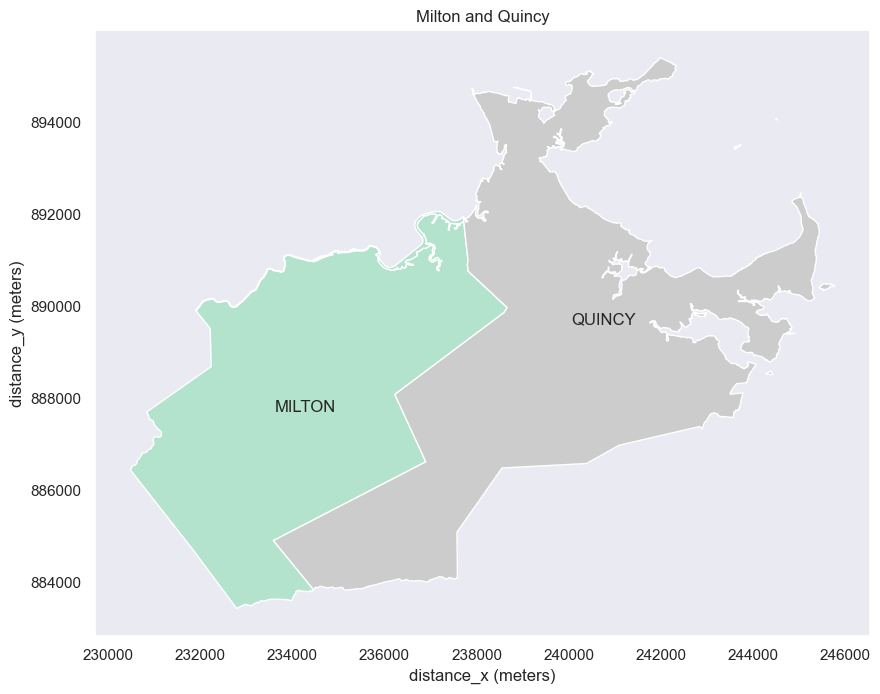

In [8]:
fig, ax = plt.subplots(1, figsize=(10,10))
mm.plot_map(milton_quincy_boundaries,
                 column="TOWN",
                 cmap="Pastel2",
                 title="Milton and Quincy",
                 legend=False,
                 ax=ax)
for i in milton_quincy_boundaries.index:
    x = town_boundaries.loc[[i]].representative_point().x
    y = town_boundaries.loc[[i]].representative_point().y
    plt.annotate(town_boundaries.loc[i, "TOWN"], (x,y))

plt.show()

Let's join on the polygons for open spaces within Milton.

## Open space maps

A shapefile of open and recreational space plots in Massachusetts was downloaded from [the mass.gov website](https://www.mass.gov/info-details/massgis-data-protected-and-recreational-openspace#downloads-).  It is provided with the following disclaimer:

> These data are very useful for most statewide and regional planning purposes. However, they are not a legal record of ownership, and the user should understand that parcel representations are generally not based on property surveys.

The data documentation from the download page above has been saved as a PDF locally <../data/L3_SHP_M189_Milton/MassGIS\ Data_\ Protected\ and\ Recreational\ OpenSpace\ _\ Mass.gov.pdf>)

In [9]:
openspace.MANAGER.fillna("N/A").value_counts()

N/A                                                                                           254
City of Quincy Parks and Forestry Department                                                   67
City of Quincy Parks and Recreation Department                                                 16
City of Quincy School Department                                                               16
Town of Milton Parks Department                                                                13
City of Quincy Conservation Commission                                                         12
Town of Milton Conservation Commission                                                         10
Granite Links Golf Course                                                                       7
Town of Milton School Department                                                                5
Town of Milton                                                                                  5
City of Quincy Cemet

In [10]:
openspace['MANAGER'] = openspace.MANAGER.fillna("N/A")

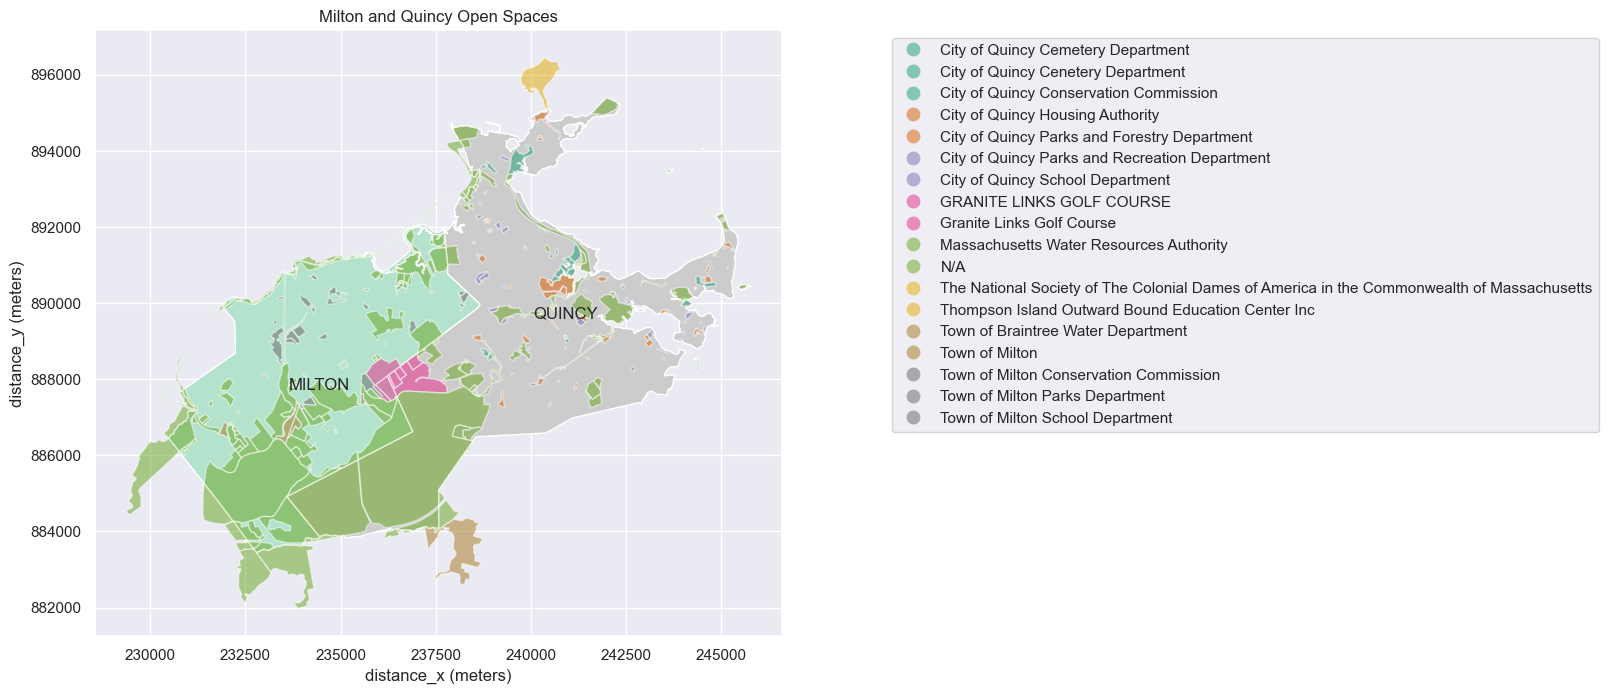

<Figure size 1500x800 with 0 Axes>

In [11]:
mm.plot_map(openspace,
            column="MANAGER",
            cmap="Dark2",
            ax=ax,
            legend_shift=2.2,
            title="Milton and Quincy Open Spaces",
            alpha=0.5)
display(fig)

In [14]:
map_center = milton_quincy_boundaries.dissolve().centroid.to_crs(epsg=4326)[0]

In [15]:
milton_map = folium.Map(width=800,height=800, location=[map_center.y, map_center.x], zoom_start=12)
folium.GeoJson(milton_quincy_boundaries.geometry).add_to(milton_map)
display(milton_map)

In [16]:
pub_access_values = list(openspace.PUB_ACCESS.unique())
pub_access_values

['Y', 'L', 'N', 'X']

Public access value codes:

Y - Yes (open to public)
N - No (not open to public)
L - Limited (membership only)
X - Unknown

In [22]:
openspace[openspace.MANAGER=="N/A"]

,TOWN_ID,POLY_ID,SITE_NAME,FEE_OWNER,OWNER_ABRV,OWNER_TYPE,MANAGER,MANAGR_ABR,MANAGR_TYP,PRIM_PURP,...,INTSYM,OS_ID,CAL_DATE_R,FORMAL_SIT,CR_REF,OS_TYPE,EEA_CR_ID,SHAPE_AREA,SHAPE_LEN,geometry
13,243,3390,Eastern Nazarene College Tennis Courts,Eastern Nazarene College,None,N,N/A,None,None,R,...,None,243-3390,None,None,0,None,None,8364.347418,399.706723,"POLYGON ((240535.001 891277.978, 240535.458 89..."
14,243,3391,Eastern Nazarene College Tennis Courts,Eastern Nazarene College,None,N,N/A,None,None,R,...,None,243-3391,None,None,0,None,None,15786.202308,562.948830,"POLYGON ((240494.234 891381.153, 240487.814 89..."
24,243,3428,McIntyre Mall,City of Quincy,M243,M,N/A,None,None,R,...,None,243-3428,None,None,0,None,None,793.653177,129.009700,"POLYGON ((240933.575 889143.005, 240888.094 88..."
25,243,3429,McIntyre Mall,City of Quincy,M243,M,N/A,None,None,R,...,None,243-3429,None,None,0,None,None,1433.364764,195.921490,"POLYGON ((240887.541 889142.441, 240881.959 88..."
39,243,355,Post Island Beach,City of Quincy,M243,M,N/A,None,None,R,...,None,243-355,None,None,0,None,None,14502.102889,1270.040770,"POLYGON ((243376.869 890472.510, 243437.062 89..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,243,3437,Quincy Shore Reservation,DCR - Division of State Parks and Recreation,DCRS,S,N/A,None,None,R,...,None,243-3437,1975-12-09,None,0,None,None,838.435625,114.685432,"POLYGON ((240336.200 891953.512, 240360.729 89..."
412,243,3436,Quincy Shore Reservation,DCR - Division of State Parks and Recreation,DCRS,S,N/A,None,None,R,...,None,243-3436,1975-12-09,None,0,None,None,2152.118190,202.598355,"POLYGON ((240455.400 891895.394, 240445.826 89..."
413,243,3438,Quincy Shore Reservation,DCR - Division of State Parks and Recreation,DCRS,S,N/A,None,None,R,...,None,243-3438,1975-12-09,None,0,None,None,687.437507,105.347519,"POLYGON ((240387.605 891924.900, 240382.926 89..."
414,243,3439,Quincy Shore Reservation,DCR - Division of State Parks and Recreation,DCRS,S,N/A,None,None,B,...,None,243-3439,None,None,0,None,None,35798.193991,1081.471289,"POLYGON ((241343.965 891024.802, 241324.810 89..."


In [20]:
milton_map = folium.Map(width=800,height=800, location=[map_center.y, map_center.x], zoom_start=12)

sf, cm_dict = mm.make_choropleth_style_function(openspace, "PUB_ACCESS", "Dark2")

#Print a legend
display(Markdown(mm.html_legend(cm_dict)))

folium.GeoJson(milton_quincy_boundaries.geometry).add_to(milton_map)
folium.GeoJson(data=openspace,
               style_function=sf,
               popup=folium.GeoJsonPopup(
                   fields=['SITE_NAME', 'MANAGER', 'GIS_ACRES'],
                   aliases=['Name','Managed by','Acres']
               )).add_to(milton_map)
display(milton_map)


<table>
  <tr>
    <th>Value</th>
    <th>Color</th>
  </tr>
<tr><td><span style="font-family: monospace">Y</span></td> <td><span style="color: #1b9e77">████████</span></td></tr>
<tr><td><span style="font-family: monospace">L</span></td> <td><span style="color: #d95f02">████████</span></td></tr>
<tr><td><span style="font-family: monospace">N</span></td> <td><span style="color: #7570b3">████████</span></td></tr>
<tr><td><span style="font-family: monospace">X</span></td> <td><span style="color: #e7298a">████████</span></td></tr></table>

## Parcel Shapefile

Downloaded from [mass.gov property tax parcel](https://www.mass.gov/info-details/massgis-data-property-tax-parcels#downloads-).  The files are offered with the following disclaimer:

> Assessor’s parcel mapping is a representation of property boundaries, not an authoritative source. The authoritative record of property boundaries is recorded at the registries of deeds. A legally authoritative map of property boundaries can only be produced by a professional land surveyor.

Data dictionary and other documentation are provided in the Parcel Standard, which has been downloaded as PDF to `../data/L3_SHP_M189_Milton/Parcel_Standard_Version3.pdf`

A critical field is `POLY_TYPE`, which will allow us to filter down to residential parcels.  The value definitions are:

* FEE - Most polygons will be coded “FEE”, including polygons owned by non-profit or state
government organizations.
* TAX – This is used when the polygon is created by dissolving the constituent deeded parcels
because assessor information about these parcels has been combined.
* WATER - Polygons may be coded “WATER” when a body of water participates in representing
the boundary of one or more parcel polygons.
* ROW – this attribute value indicates a public right of way, usually for motorized vehicles.
* PRIV_ROW – these are rights of way, usually for motorized vehicles, that are not publicly owned.
They may provide access to a public right of way, but even so are still mapped as separate
polygons. Polygons classified as PRIV_ROW only occur as discrete polygons that do not overlap
with other polygons in TaxPar.
* RAIL_ROW – these are railroad rights of way. When a “RAIL_ROW” crosses a “ROW” or
* PRIV_ROW at a grade crossing, the “RAIL_ROW” “breaks” the “ROW” or “PRIV_ROW”


In [ ]:
tax_parcels.head()

In [ ]:
tax_parcels.plot(column="POLY_TYPE", legend=True)

In [ ]:
sf, cm_dict = make_chloropleth_style_function(tax_parcels, "POLY_TYPE", "Dark2")

folium.GeoJson(milton_boundaries.geometry).add_to(milton_map)
folium.GeoJson(tax_parcels, style_function=sf).add_to(milton_map)
display(milton_map)
#Print a legend
display(Markdown('<br>'.join(
    f'<span style="font-family: monospace">{code} <span style="color: {color}">████████</span></span>'
    for code, color in cm_dict.items()
)))

## Calculate distance of each tax parcel to nearest openspace

As a first pass, let's filter down to `POLY_TYPE` of "FEE" or "TAX", since residential parcels appear to all be one or the other.  However, non-residential parcels are also included.  Let's also consider only open space parcels marked as publicly accessible.

In [ ]:
building_parcels = tax_parcels[tax_parcels.POLY_TYPE.isin(["FEE", "TAX"])]
accessible_openspace = milton_openspace[milton_openspace['PUB_ACCESS']=="Y"].drop(columns=["index_right"])

In [ ]:
accessible_openspace.shape

In [ ]:
#iloc[list] syntax returns a GeoDataFrame rather than a pandas series so we can still plot
poly1 = building_parcels.iloc[[0]]
poly2 = accessible_openspace.iloc[[0]]
ax = poly1.plot()
poly2.plot(ax=ax)

The `sjoin_nearest` method requires `geopy` to be installed, which is not included by default with geopandas.

```
mamba install -c conda-forge geopy
```
will do the trick

In [ ]:
result = gpd.sjoin_nearest(building_parcels, accessible_openspace, how="left", distance_col="distance_to_openspace")
result.head()

`result` has one row per tax parcel.  The ID of the closest openspace parcel to the tax parcel is in column `index_right`, and the distance to that parcel is in `distance_to_openspace`.

What are the distance units?  That depends on the CRS.

In [ ]:
result.crs

Apparently the coordinates are in meters.

In [ ]:
result.shape

In [ ]:
sns.set_context("talk")
g = sns.displot(result.reset_index(), x='distance_to_openspace')
g.set(xlabel="Distance to public openspace (meters)",
      ylabel="Number of tax parcels",
      title="Distribution of distance to openspace by tax parcel in Milton, MA")
plt.show()

### Validating that the calculation means what I think it means

In [ ]:
test_row = result.loc[12]
print(test_row.index_right, test_row.distance_to_openspace)

In [ ]:
accessible_openspace.loc[39158]

In [ ]:
ax = result.loc[[12]].plot()
accessible_openspace.loc[[54533]].plot(ax=ax, color='red')

In [ ]:
poly1 = result.loc[12, 'geometry']
poly2 = accessible_openspace.loc[54533, 'geometry']
poly1.distance(poly2)

In [ ]:
from shapely.geometry import Point, Polygon
poly1_points = [Point(x, y) for x,y in poly1.exterior.coords]
poly2_points = [Point(x, y) for x,y in poly2.exterior.coords]

min_value = 1e6
for p1 in poly1_points:
    for p2 in poly2_points:
        d = p1.distance(p2)
        print(d)
        if d < min_value:
            min_value = d

print(f"Minimum distance: {min_value}")

In [ ]:
p1 = Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]])
p1

In [ ]:
p2 = Polygon([[1, 0.5], [1.5, 1], [2, 0.5], [1.5, 0]])
p2

In [ ]:
p1.distance(p2)

In [ ]:
poly1_points = [Point(x, y) for x,y in p1.exterior.coords]
poly2_points = [Point(x, y) for x,y in p2.exterior.coords]

min_value = 1e6
for p1 in poly1_points:
    for p2 in poly2_points:
        d = p1.distance(p2)
        print(d)
        if d < min_value:
            min_value = d

print(f"Minimum distance: {min_value}")

## Join to geodatabase attributes to identify residential parcels

We are lacking sufficient info in the parcel shapefile to filter down to residential parcels. According to the parcel standard, the assessor's database record includes two fields likely to be of assistance:

* PROP_ID – Assessor records include the identifier used to identify the parcel on the assessor map to which the assessing record applies. The PROP_ID is typically stored as the map number, the block designation, and the lot designation or similar references. When those identifying references are combined, they typically match the parcel ID (See MAP_PAR_ID in this standard) on the mapping. The PROP_ID must be unique within the city or town.
* UNITS – Number of living/dwelling units and also other units, for example, commercial condos and storage units in a warehouse (this was formerly named “LIV_UNITS” in previous standard version.)
* RES_AREA – Total residential living area in square feet (not gross building area) as defined by the assessor (e.g., this may or may not include only heated space). This is a useful attribute when evaluating development proposals relative to surrounding residences, but a difficult one to create because it may require adding areas from multiple fields in the assessor’s database. This information applies primarily to 1, 2 & 3 family dwellings based on exterior building measurements or residential condominiums based on deeded unit areas. Building area may be recorded as gross square-feet, adjusted gross square-feet, or finished area. Basement area may or may not be included in finished area. Partial story-heights and attic areas may be treated differently by different CAMA systems. Gross area may include non-living areas such as porches and decks or attached garages.

Perhaps these attributes can be found in the `gdb` file.

In [ ]:
import fiona
fiona.listlayers("../data/M189_parcels_CY22_FY22_sde.gdb")

In [ ]:
path = "../data/M189_parcels_CY22_FY22_sde.gdb"
f = fiona.open(path, 'r', layer='M189Assess')

In [ ]:
type(f)

In [ ]:
thing = f.next()

In [ ]:
thing

In [ ]:
path = "../data/M189_parcels_CY22_FY22_sde.gdb"
def yield_features(path):
    with fiona.open(path, 'r', layer="M189Assess") as f:
        for feature in f:
            yield feature['properties']

features = yield_features(path)

assessor_df = pd.DataFrame.from_records(features)

In [ ]:
assessor_df.head()

In [ ]:
assessor_df[assessor_df.OWNER1.str.contains("HASHA")]

In [ ]:
#building_parcels.head()
building_parcels.loc[building_parcels.MAP_PAR_ID=="N 6A 2"]

## Explore assessor database

In [ ]:
from collections import defaultdict

In [ ]:
assessor_df.info()

In [ ]:
output_file = "blahblahblah.PKL"
output_file[-3:].lower()

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(assessor_df, title="Assessor Database Profile")

In [ ]:
sns.countplot(x="UNITS", data=assessor_df)
plt.xticks(rotation=45)
plt.show()

In [ ]:
assessor_df['RES_AREA'].quantile([0.1,0.25,0.5,0.75, 0.9])

In [ ]:
assessor_df[assessor_df.RES_AREA==0].shape

In [ ]:
assessor_df.USE_CODE.value_counts()

In [ ]:
assessor_df.iloc[2].USE_CODE

Use codes as defined by the [codebook](https://www.mass.gov/files/documents/2016/08/wr/classificationcodebook.pdf)

In [ ]:
use_codes = {
    '101': "Single Family",
    '102': "Condominium",
    '103': "Mobile Home",
    '104': "Two-Family",
    '105': "Three-Family",
    '106': "Accessory Land with Improvement - garage,etc.",
    '109': "Multiple Houses on one parcel (for example, a single and a two-family on one parcel)",
    '132': "Undevelopable Land",
    '930': "Municipal, Vacant, Selectmen or City Council",
    '130': "Vacant Land in a Residential Zone or Accessory to Residential Parcel, Developable Land",
    '343': "Office Building", #There is no code 343 in the cited reference, but prefix 34 indicates office buildings.
    '131': "Vacant Land in a Residential Zone or Accessory to Residential Parcel, Potentially Developable Land",
    '945': "Educational Private, Affilliated Housing",
    '942': "Educational Private, College or University",
    '920': "Department of Conservation and Recreation, Division of Urban Parks and Recreation",
    '340': "General Office Buildings",
    '931': "Municipal, Improved, Selectmen or City Council",
    '960': "Church, Mosque, Synagogue, Temple, etc",
    '325': "Small Retail and Services stores (under 10,000 sq. ft.)",
    '337': "Parking Lots - a commercial open parking lot for motor vehicles",
    '932': "Municipal, Vacant, Conservation",
    '013': "Multiple-Use, primarily Residential",
    '031': "Multiple-Use, primarily Commercial",
    '950': "Charitable, Vacant, Conservation Organizations"
}

def use_codes_map(use_code):
    try:
        use_description = use_codes[use_code]
    except KeyError:
        use_description = "Other"

    return use_description

residential_codes = ['101', '102', '103', '104', '105', '109', '013']


In [ ]:
assessor_df['USE_DESCRIPTION'] = assessor_df['USE_CODE'].map(use_codes_map)
assessor_df['IS_RESIDENTIAL'] = assessor_df['USE_CODE'].isin(residential_codes)

In [ ]:
sns.countplot(x="IS_RESIDENTIAL", data=assessor_df, order=[True, False])
plt.title("Most Milton parcels are residential")
plt.show()

In [ ]:
res_assessor_df = assessor_df[assessor_df.IS_RESIDENTIAL]
g = sns.countplot(x="STYLE",
                  data=res_assessor_df,
                  order=res_assessor_df['STYLE'].value_counts().index)
plt.title("Colonials are by far the most popular building style in Milton")
plt.xticks(rotation=45)
plt.show()

In [ ]:
df = assessor_df[(assessor_df.STYLE.isin(["COLONIAL", "OLD STYLE", "CAPE", "RANCH"])) & assessor_df.IS_RESIDENTIAL]
g = sns.relplot(x='YEAR_BUILT', y='RES_AREA',
                col="STYLE",
                #col_order=assessor_df.STYLE.value_counts().index,
                #col_wrap=True,
                data=df, kind="scatter")
g.set(yscale="log",
      xlim=[1900,2020])
g.fig.suptitle("Colonials have remained popular, and increased in size")
plt.show()

In [ ]:
assessor_df.loc[assessor_df.RES_AREA==0]

## Join tax parcel geometries to assessor DB

We join the assessor database attributes to the tax parcel geometries in order to filter down to residential properties

In [ ]:
tax_parcels.head()

In [ ]:
residential_parcels = pd.merge(
    tax_parcels,
    assessor_df.loc[assessor_df.IS_RESIDENTIAL, ["PROP_ID", "LOC_ID", "YEAR_BUILT", "USE_DESCRIPTION", "RES_AREA", "ZONING", "LOT_SIZE", "TOTAL_VAL", "LAND_VAL", "SITE_ADDR"]],
    on="LOC_ID",
    how="inner"
)

residential_parcels.shape

In [ ]:
res_assessor_df.shape

In [ ]:
residential_parcels[residential_parcels.SITE_ADDR.str.contains("NAHANTON AV")]

In [ ]:
res_assessor_df[res_assessor_df.PROP_ID=='N 4 12']

In [ ]:
tax_parcels.info()

In [ ]:
assessor_df.info()

## Calculate distribution of distance to openspace for residential parcels

In [ ]:
result = gpd.sjoin_nearest(residential_parcels, accessible_openspace, how="left", distance_col="distance_to_openspace")
result.head()

In [ ]:
g = sns.displot(result.reset_index(), x='distance_to_openspace')
g.set(xlabel="Distance to public openspace (meters)",
      ylabel="Number of residential parcels",
      title="Distribution of distance to openspace by tax parcel in Milton, MA")
plt.show()

In [ ]:
result.distance_to_openspace.quantile([0.1,0.25,0.5,0.75,0.9, 1])

In [ ]:
x = result[result.distance_to_openspace > 970]
x.transpose()